In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
from matplotlib import pyplot as plt
%matplotlib inline

import glob

# suppress natural naming warnings
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

## Defines Settings

In [2]:
selection_version = 'version-001-p00'

plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/reconstruction_resolution/selection_{}'.format(selection_version)
df_dir = '/data/ana/PointSource/DNNCascade/analysis/{}/'.format(selection_version)


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
dfs = {}

print('Loading BFRv1 ...')
dfs['BFRv1'] = pd.read_hdf(
    df_dir + '/MC_NuGen_bfrv1_2153x.hdf', key='df',
)

print('Loading SnowStorm ...')
dfs['SnowStorm']  = pd.read_hdf(
    df_dir + '/systematics/SnowStorm_Spice321/MC_NuGen_snowstorm_214xx.hdf', key='df',
)

print('Loading exp ...')
df_exp_list = []
for y in range(2011, 2021):
     df_exp_list.append(pd.read_hdf(
        '{}/IC86_{}_exp.hdf'.format(df_dir, y), key='df',
    ))
dfs['_exp']  = pd.concat(df_exp_list, ignore_index=True)

print('Loading MuonGun ...')
dfs['MuonGun']  = pd.read_hdf(
    df_dir + '/MC_MuonGun_2131x.hdf', key='df',
)

print('Loading CORSIKA ...')
dfs['CORSIKA']  = pd.read_hdf(
    df_dir + '/MC_CORSIKA_20904.hdf', key='df',
) 


Loading BFRv1 ...
Loading SnowStorm ...
Loading exp ...
Loading MuonGun ...
Loading CORSIKA ...


## Livetime and Burnsample

In [5]:
mask_burn = dfs['_exp']['I3EventHeader_Run'] % 10 == 0
dfs['exp'] = dfs['_exp'][mask_burn]

burnsample_fraction = np.sum(mask_burn) / len(dfs['_exp'])
print('Burn sample fraction: {:3.3f}%'.format(burnsample_fraction * 100))

for name, df in dfs.items():
    if 'exp' not in name:
        print('Adjusting weights for: {}'.format(name))
        df['weights_new'] = df['weights'] * burnsample_fraction

Burn sample fraction: 9.903%
Adjusting weights for: BFRv1
Adjusting weights for: SnowStorm
Adjusting weights for: MuonGun
Adjusting weights for: CORSIKA


In [6]:
_livetime = dfs['BFRv1']['weights_livetime'].iloc[0]
livetime = _livetime * burnsample_fraction
print('Livetime: {} days'.format(_livetime / 60 / 60 / 24))
print('Livetime [Burnsample]: {} days'.format(livetime / 60 / 60 / 24))


Livetime: 3519.6846812828426 days
Livetime [Burnsample]: 348.5438462273548 days


In [7]:
dfs.keys()

dict_keys(['BFRv1', 'SnowStorm', '_exp', 'MuonGun', 'CORSIKA', 'exp'])

## Snowstorm Systematics

In [8]:
priors_dict = {
    #'Absorption': [0.930, 1.070], #[0.9, 1.0],
    #'Scattering': [0.953, 1.012], #[0.9, 1.1],
    #'AnisotropyScale': [0, 2], #[0., 2.],
    #'DOMEfficiency': [0.9, 1.1],
    #'HoleIceForward_Unified_00': [-0.800, 0.800], #[-0.65, 0.65],
    #'HoleIceForward_Unified_01': [-0.120, -0.040], #[-0.2, 0.2],
}
snowstorm_simulation_range = {
    'Scattering': [0.9, 1.1],
    'Absorption': [0.9, 1.1],
    'AnisotropyScale': [0., 2.],
    'DOMEfficiency': [0.9, 1.1],
    'HoleIceForward_Unified_00': [-1.0, 1.0],
    'HoleIceForward_Unified_01': [-0.2, 0.2],
}

def rename_snowstorm_params(df):
    parameter_names=[
        'Scattering', 'Absorption', 'AnisotropyScale', 
        'DOMEfficiency', 'HoleIceForward_Unified_00', 
        'HoleIceForward_Unified_01',
    ]
    for i, param in enumerate(parameter_names):
        df[param] = df['SnowstormParameters_{:05d}'.format(i)]

def get_snowstorm_multiplier(
        df,
        priors_dict,
        simulation_range=snowstorm_simulation_range,
        verbose=False,
    ):
    """Reweight snowstorm
    
    Parameters
    ----------
    df: DataFrame or dict
        The dataframe or dictionary containing the SnowStorm
        parameters. 
    priors_dict : dict
        A dictionary with uniform Snowstorm priors defined
        as a tuple of (min, max).
    """
    w_multiplier = 1.0
    mask = np.ones_like(df[list(simulation_range.keys())[0]], dtype=bool)
    for name, prior in priors_dict.items():
        
        prior_orig = simulation_range[name]
        assert prior[1] >= prior[0] and prior_orig[1] >= prior_orig[0]
        assert prior[0] >= prior_orig[0] and prior[0] <= prior_orig[1]
        assert prior[1] >= prior_orig[0] and prior[1] <= prior_orig[1]
        
        range_sim = prior_orig[1] - prior_orig[0]
        range_new = prior[1] - prior[0]
        w_multiplier *= range_sim / range_new
        mask = np.logical_and(mask, df[name] >= prior[0])
        mask = np.logical_and(mask, df[name] <= prior[1])
    
    
    snowstorm_multiplier = np.ones_like(mask) * mask.astype(float) * w_multiplier
    if verbose:
        print(np.sum(mask) / float(len(mask)), 1./w_multiplier, w_multiplier)
        print(np.sum(mask), len(mask), np.sum(snowstorm_multiplier))
    return snowstorm_multiplier
        
if 'SnowStorm' in dfs:
    print('Reweighting Snowstorm set')
    rename_snowstorm_params(dfs['SnowStorm'])
    dfs['SnowStorm']['snowstorm_multiplier'] = get_snowstorm_multiplier(
        df=dfs['SnowStorm'],
        priors_dict=priors_dict,
        verbose=True,
    )



Reweighting Snowstorm set
1.0 1.0 1.0
2217128 2217128 2217128.0


## Compute Containment

In [9]:
from dnn_cascade_selection.utils.notebook import coordinates
from ic3_labels.labels.utils import geometry

def add_distance_to_hull(df, reco_key='EventGeneratorSelectedRecoNN_I3Particle'):
    pos = np.array([
        df[reco_key + '_x'],
        df[reco_key + '_y'],
        df[reco_key + '_z'],
    ]).T
    distances = np.empty_like(df[reco_key + '_x'])
    for i, pos_i in tqdm(enumerate(pos), total=len(pos)):
        distances[i] = geometry.distance_to_icecube_hull(pos_i)
    df['distance_hull'] = distances
        
add_distance_to_hull(dfs['MuonGun'])
add_distance_to_hull(dfs['CORSIKA'])
add_distance_to_hull(dfs['exp'])
add_distance_to_hull(dfs['BFRv1'])


  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/5903 [00:00<?, ?it/s]

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


  0%|          | 0/398873 [00:00<?, ?it/s]

## Compute Opening Angle

In [10]:

def compute_opening_angle(df, reco_key='EventGeneratorSelectedRecoNN_I3Particle'):
    dpsi = coordinates.get_angle_deviation(
        azimuth1=df[reco_key + '_azimuth'], 
        zenith1=df[reco_key + '_zenith'], 
        azimuth2=df['LabelsDeepLearning_PrimaryAzimuth'], 
        zenith2=df['LabelsDeepLearning_PrimaryZenith'], 
    )
    df['dpsi'] = dpsi
    df['dpsi_deg'] = np.rad2deg(dpsi)

compute_opening_angle(dfs['MuonGun'])
compute_opening_angle(dfs['CORSIKA'])
compute_opening_angle(dfs['BFRv1'])

## Create Combined MC DataFrame

In [11]:
nugen_keys = ['BFRv1']
muon_keys = ['MuonGun', 'CORSIKA']

shared_keys = None
for name, df in dfs.items():
    if 'exp' not in name:
        if shared_keys is None:
            shared_keys = set(df.columns.values)
        else:
            shared_keys = shared_keys.intersection(
                set(df.columns.values))

df_list = []
for name in nugen_keys:
    print('NuGen:', name)
    df_red = dfs[name][list(shared_keys)]
    df_red['mc_origin'] = 'NuGen_' + name
    df_list.append(df_red)
for name in muon_keys:
    print('Muon:', name)
    df_red = dfs[name][list(shared_keys)]
    df_red['mc_origin'] = 'Muon_' + name
    df_list.append(df_red)
    
df_mc = pd.concat(df_list, ignore_index=True)
del df_list
print(len(df_mc))

NuGen: BFRv1


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Muon: MuonGun
Muon: CORSIKA
399400


## Plot Helpers

In [12]:
convert = {
    'distance_hull': 'Distance to convex hull /m ',
    'LabelsDeepLearning_TotalDepositedEnergy': 'In detector deposited EM energy / GeV',
    'LabelsDeepLearning_EnergyVisible': 'Visible energy / GeV',
    'LabelsDeepLearning_PrimaryEnergy': 'Neutrino energy / GeV',
    'EventGeneratorSelectedRecoNN_I3Particle_z': 'Reconstructed vertex-$z$ / m',
    'EventGeneratorSelectedRecoNN_I3Particle_energy': r'Reconstructed energy $E_\mathrm{reco}$ / GeV',
    'EventGeneratorSelectedRecoNNCircularUncertainty': r'Angular uncertainty $\sigma_\mathrm{reco}$ [uncorrected]',
    'angErr': r'Angular uncertainty $\sigma_\mathrm{reco}$',
}

In [106]:
import matplotlib as mpl
from cycler import cycle
from copy import deepcopy
import csky as cy
import histlite as hl

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)

def plot_1d_quantity(
            df, x_key, quantity_func, 
            x_edges, x_width,
            x_width_in_log=False,
            label_quantity=None,
            label=None,
            color=None, ls='-',
            fig=None, ax=None, figsize=(6, 4),
            mask_func=None,
        ):
    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if mask_func is None:
        mask = np.ones_like(df[x_key], dtype=bool)
    else:
        mask = mask_func(df)
    
    x_mids = x_edges[:-1] + 0.5 * np.diff(x_edges)
    
    values = np.empty(len(x_mids))
    errors = np.empty(len(x_mids)) * np.nan
    errors_exist = False
    
    # walk through each bin and compute quantity
    for i, x_mid in tqdm(enumerate(x_mids), total=len(x_mids)):
        if x_width_in_log:
            mask_x = np.logical_and(
                np.log10(df[x_key]) >= np.log10(x_mid) - x_width, 
                np.log10(df[x_key]) < np.log10(x_mid) + x_width, 
            )
        else:
            mask_x = np.logical_and(
                df[x_key] >= x_mid - x_width, 
                df[x_key] < x_mid + x_width, 
            )
            
        mask_i = mask & mask_x
        res = quantity_func(df=df, mask=mask_i)
        if isinstance(res, (float, int)):
            values[i] = res
        else:
            values[i] = res[0]
            errors[i] = res[1]
            errors_exist = True
    
    if errors_exist:
        if x_width_in_log:
            xerr = (10**(np.log10(x_mids) - x_width) - x_mids, 10**(np.log10(x_mids) + x_width) - x_mids)
        else:
            xerr = x_width
        ax.errorbar(x_mids, values, xerr=xerr, yerr=errors, ls=ls, label=label, color=color, fmt='o')
    else:
        ax.plot(x_mids, values, ls=ls, label=label, color=color)
    ax.set_xlabel(convert.get(x_key, x_key))
    ax.set_ylabel(label_quantity)
    return fig, ax

def plot_2d_quantity(
            df, x_key, y_key, quantity_func, 
            x_edges, y_edges, x_width, y_width,
            x_width_in_log=False,
            y_width_in_log=False,
            label_quantity=None,
            fig=None, ax=None, figsize=(9, 6),
            mask_func=None,
            vmin=None, vmax=None, norm='log',
            cmap=plt.cm.get_cmap('viridis', 15),
        ):
    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if mask_func is None:
        mask = np.ones_like(df[x_key], dtype=bool)
    else:
        mask = mask_func(df)
    
    x_mids = x_edges[:-1] + 0.5 * np.diff(x_edges)
    y_mids = y_edges[:-1] + 0.5 * np.diff(y_edges)
    
    if isinstance(norm, str):
        if norm == 'log':
            norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        elif norm == 'linear':
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        else:
            raise ValueError('Unkown normalization:', norm)
    
    shape = (len(x_mids), len(y_mids))
    values = np.empty(shape)
    
    # walk through each bin and compute quantity
    for i, x_mid in tqdm(enumerate(x_mids), total=len(x_mids)):
        for j, y_mid in enumerate(y_mids):
            
            if x_width_in_log:
                mask_x = np.logical_and(
                    np.log10(df[x_key]) >= np.log10(x_mid) - x_width, 
                    np.log10(df[x_key]) < np.log10(x_mid) + x_width, 
                )
            else:
                mask_x = np.logical_and(
                    df[x_key] >= x_mid - x_width, 
                    df[x_key] < x_mid + x_width, 
                )
            
            if y_width_in_log:
                mask_y = np.logical_and(
                    np.log10(df[y_key]) >= np.log10(y_mid) - y_width, 
                    np.log10(df[y_key]) < np.log10(y_mid) + y_width, 
                )
            else:
                mask_y = np.logical_and(
                    df[y_key] >= y_mid - y_width, 
                    df[y_key] < y_mid + y_width, 
                )
            mask_i = mask & mask_x & mask_y
            
            quantity = quantity_func(df=df, mask=mask_i)
            values[i, j] = quantity
    
    
    im = ax.pcolormesh(x_edges, y_edges, values.T, norm=norm, cmap=cmap)
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(label_quantity)
    ax.set_xlabel(convert.get(x_key, x_key))
    ax.set_ylabel(convert.get(y_key, y_key))
    return fig, ax


def plot_resolution(
            df, x_key, y_key, 
            bins=np.logspace(np.log10(500), 7, 30), 
            fig=None, ax=None, figsize=(9, 6),
            normalize_column=True,
            density=True,
            mask_func=None,
            vmin=None, vmax=None,
        ):
    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if mask_func is None:
        mask = np.ones_like(df[x_key], dtype=bool)
    else:
        mask = mask_func(df)
    
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    if normalize_column:
        H, xedges, yedges = np.histogram2d(
            df[x_key][mask], df[y_key][mask], bins=bins, weights=df['weights'][mask],
        )
        H /= np.sum(H, axis=1, keepdims=True)
        im = ax.pcolormesh(xedges, yedges, H.T, norm=norm)

    else:
        h, _, _, im = ax.hist2d(
            df[x_key][mask], df[y_key][mask], bins=bins, weights=df['weights'][mask], 
            density=True, norm=norm,
        )
    cb = plt.colorbar(im, ax=ax)
    if normalize_column:
        cb.set_label('Density (normalized along columns)')
    else:
        cb.set_label('Density')
    ax.set_xlabel(convert.get(x_key, x_key))
    ax.set_ylabel(convert.get(y_key, y_key))
    ax.set_xscale('log')
    ax.set_yscale('log')
    return fig, ax

def plot_angular_resolution(
            df, 
            key_x='LabelsDeepLearning_PrimaryEnergy', 
            xlabel=r'$E_\mathrm{true}$ / GeV',
            bins=(10**np.r_[2.25:8.26:.45], np.r_[0:40.01:.01]),
            fig=None, ax=None, figsize=(9, 6),
            xscale='log',
            color=soft_colors[0],
            mask_func=None,
        ):
    
    if mask_func is None:
        mask = np.ones_like(df[key_x], dtype=bool)
    else:
        mask = mask_func(df)
    
    # create a histogram:
    h = hl.hist_slide(
        # slide the bins 5 times along energy, hold them still along angular error
        (5,1),
        # 2D histogram of true energy and angular error in degrees
        (df[key_x][mask], df['dpsi_deg'][mask]),
        # weighting
        df['weights'][mask],
        bins=bins,
    )

    # normalize along the angular error axis
    h = h.normalize(1)
    # get 20%, 50%, and 80% quantiles
    h2 = h.contain(1, .2)
    h5 = h.contain(1, .5)
    h8 = h.contain(1, .8)
    
    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    # plot quantiles, emphasize median
    hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
    hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

    # trick to get the legend handles colored right
    # try testing what happens if you just do hl.fill_between(..., label='...')
    nans = [np.nan, np.nan]
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='$80\%$')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='$50\%$')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='$20\%$')

    # labels etc
    ax.set_xscale(xscale)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r'$\Delta\Psi[\mathrm{true,reco}]~/^\circ$')
    ax.set_xlim(h.bins[0][1], h.bins[0][-2])
    ax.set_ylim(0)
    ax.legend(loc='upper right')
    plt.tight_layout()
    
    return fig, ax


def plot_hist(
            key, bins,
            fig=None, ax=None, figsize=(9, 6),
            density=False,
            mask_func=None,
            ls=None,
            colors=colors,
            add_labels=True,
            dfs_to_plot=['exp', 'BFRv1', 'MuonGun', 'CORSIKA'],
        ):
    
    color_cycle = cycle(colors)
    
    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if 'exp' in dfs_to_plot:
        if mask_func is None:
            values = dfs['exp'][key]
        else:
            values = dfs['exp'][key][mask_func(dfs['exp'])]
        if add_labels:
            label = 'exp'
        else:
            label = None
        ax.hist(values, bins=bins, histtype='step', density=density, ls=ls, label=label, color=next(color_cycle))
    
    for k in ['BFRv1', 'MuonGun', 'CORSIKA']:
        if k in dfs_to_plot:
            if mask_func is None:
                mask = np.ones_like(dfs[k][key], dtype=bool)
            else:
                mask = mask_func(dfs[k])
            if add_labels:
                label = k
            else:
                label = None
            ax.hist(
                dfs[k][key][mask], bins=bins, weights=dfs[k]['weights_new'][mask], 
                histtype='step', density=density, label=label, ls=ls, color=next(color_cycle),
            )
    ax.legend()  
    ax.set_xlabel(key)
    if density:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('Number of Events')
    ax.set_yscale('log')
    ax.set_ylim(1e-1)
    return fig, ax
    


### Masked Plots

In [107]:
def get_contained_mask(df):
    return df['distance_hull'] < 0

def get_non_contained_mask(df):
    return ~get_contained_mask(df)

dust_lower = -150
dust_upper = 0

def get_dust_layer_mask(df):
    reco_key='EventGeneratorSelectedRecoNN_I3Particle'
    mask = np.logical_and(
        df[reco_key + '_z'] >= dust_lower,
        df[reco_key + '_z'] <= dust_upper,
    )
    return mask

def get_non_dust_layer_mask(df):
    return ~get_dust_layer_mask(df)


#### Fraction outside as function of energy

x_width: 0.08835049992773292


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

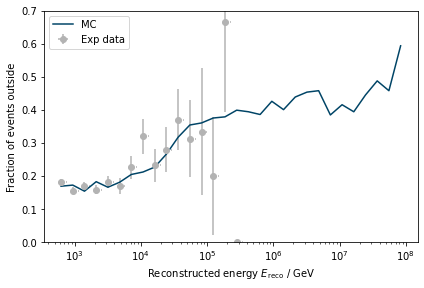

In [110]:
def quantity_func(df, mask, with_err=False):
    if np.sum(mask) <= 1:
        return np.nan
    if 'weights' in df:
        n_out = np.sum(df['weights'][mask & get_non_contained_mask(df)])
        n_total = np.sum(df['weights'][mask])
        fr = np.sum(df['weights'][mask & get_non_contained_mask(df)]) / np.sum(df['weights'][mask])
    else:
        n_out = np.sum(mask & get_non_contained_mask(df))
        n_total = np.sum(mask)
        fr = np.sum(mask & get_non_contained_mask(df)) * 1. / np.sum(mask)
                          
    h_out = hl.Hist(bins=(0, 1), values=[n_out], errors=[np.sqrt(n_out)])
    h_total = hl.Hist(bins=(0, 1), values=[n_total], errors=[np.sqrt(n_total)])
    
    h_res = h_out.efficiency(h_total)
    if with_err:
        return h_res.values[0], h_res.errors[0]
    else:
        return h_res.values[0]

def quantity_func_err(df, mask, with_err=False):
    return quantity_func(df=df, mask=mask, with_err=True)

x_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'
x_edges_exp = np.linspace(np.log10(500), 8, 15)
x_edges = 10**y_edges_exp
x_width = 0.5*np.diff(y_edges_exp)[0]
print('x_width:', x_width)

fig, ax = plot_1d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    quantity_func=quantity_func, 
    x_edges=x_edges, 
    x_width=x_width, 
    x_width_in_log=True,
    color=soft_colors[0],
    label='MC',
    label_quantity='Fraction of events outside',
)
plot_1d_quantity(
    df=dfs['exp'], 
    x_key=x_key, 
    quantity_func=quantity_func_err, 
    x_edges=x_edges, 
    x_width=x_width, 
    x_width_in_log=True,
    fig=fig, ax=ax,
    color='0.7', ls=None,
    label='Exp data',
    label_quantity='Fraction of events outside',
)
fig.tight_layout()
ax.set_xscale('log')
ax.legend()
ax.set_ylim(0., 0.7)
fig.savefig(os.path.join(
    plot_dir, 'fraction_outside_1d_{}.png'.format(x_key)))

        

##### Distance Histogram

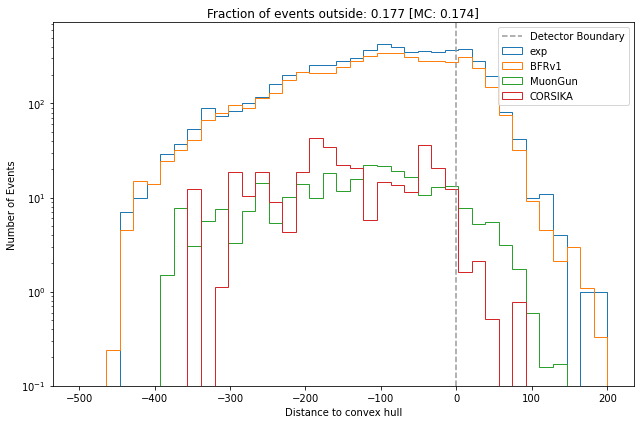

In [15]:
fig, ax = plot_hist('distance_hull', bins=np.linspace(-500, 200, 40))
ax.set_xlabel('Distance to convex hull')

fr_outside_exp = np.sum(dfs['exp']['distance_hull'] > 0) / len(dfs['exp'])
fr_outside_mc = np.sum(dfs['BFRv1']['weights_new'][dfs['BFRv1']['distance_hull'] > 0]) / np.sum(dfs['BFRv1']['weights_new'])

ax.set_title('Fraction of events outside: {:3.3f} [MC: {:3.3f}]'.format(fr_outside_exp, fr_outside_mc))
ax.axvline(0., color='0.6', ls='--', label='Detector Boundary')
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'hist_distance_hull.png'))


##### Vertex-Z Histogram

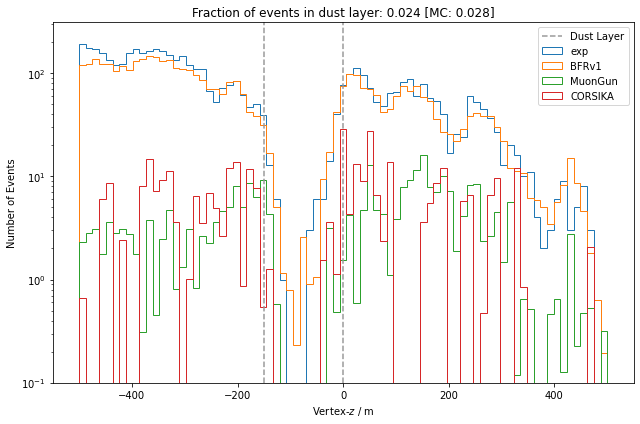

In [16]:
fig, ax = plot_hist('EventGeneratorSelectedRecoNN_I3Particle_z', bins=np.linspace(-500, 500, 80))
ax.set_xlabel('Vertex-$z$ / m')

fr_outside_exp = np.sum(get_dust_layer_mask(dfs['exp'])) / len(dfs['exp'])
fr_outside_mc = np.sum(dfs['BFRv1']['weights_new'][get_dust_layer_mask(dfs['BFRv1'])]) / np.sum(dfs['BFRv1']['weights_new'])

ax.set_title('Fraction of events in dust layer: {:3.3f} [MC: {:3.3f}]'.format(fr_outside_exp, fr_outside_mc))
ax.axvline(dust_lower, color='0.6', ls='--', label='Dust Layer')
ax.axvline(dust_upper, color='0.6', ls='--')
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'hist_vertex_z.png'))


##### Energy Hist

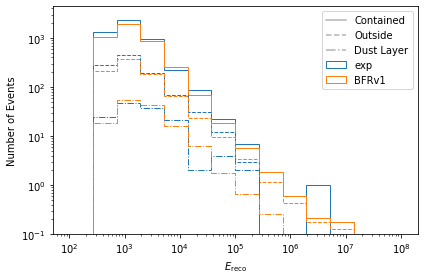

In [17]:
bins = np.logspace(2, 8, 15)
dfs_to_plot = ['exp', 'BFRv1']

fig, ax = plt.subplots(figsize=(6, 4))

plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_energy', 
    bins=bins, fig=fig, ax=ax, ls='-', add_labels=True,
    mask_func=get_contained_mask,
    dfs_to_plot=dfs_to_plot,
)
plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_energy', 
    bins=bins, fig=fig, ax=ax, ls='--', add_labels=False,
    mask_func=get_non_contained_mask,
    dfs_to_plot=dfs_to_plot,
)
plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_energy', 
    bins=bins, fig=fig, ax=ax, ls='-.', add_labels=False,
    mask_func=get_dust_layer_mask,
    dfs_to_plot=dfs_to_plot,
)
ax.set_xlabel(r'$E_\mathrm{reco}$')

ax.plot(np.inf, np.inf, color='0.7', ls='-', label='Contained')
ax.plot(np.inf, np.inf, color='0.7', ls='--', label='Outside')
ax.plot(np.inf, np.inf, color='0.7', ls='-.', label='Dust Layer')

ax.legend()
ax.set_xscale('log')
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'containment_hist_energy.png'))


#### Declination Hist

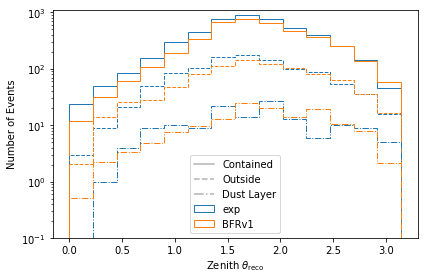

In [18]:
bins = np.linspace(0, np.pi, 15)
dfs_to_plot = ['exp', 'BFRv1']
density = False

fig, ax = plt.subplots(figsize=(6, 4))

plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_zenith', 
    bins=bins, fig=fig, ax=ax, ls='-', add_labels=True, density=density,
    mask_func=get_contained_mask,
    dfs_to_plot=dfs_to_plot,
)
plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_zenith', 
    bins=bins, fig=fig, ax=ax, ls='--', add_labels=False, density=density,
    mask_func=get_non_contained_mask,
    dfs_to_plot=dfs_to_plot,
)
plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_zenith', 
    bins=bins, fig=fig, ax=ax, ls='-.', add_labels=False, density=density,
    mask_func=get_dust_layer_mask,
    dfs_to_plot=dfs_to_plot,
)
ax.set_xlabel(r'Zenith $\theta_\mathrm{reco}$')

ax.plot(np.inf, np.inf, color='0.7', ls='-', label='Contained')
ax.plot(np.inf, np.inf, color='0.7', ls='--', label='Outside')
ax.plot(np.inf, np.inf, color='0.7', ls='-.', label='Dust Layer')

ax.legend(loc='lower center')
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'containment_hist_declination.png'))


#### Azimuth Hist

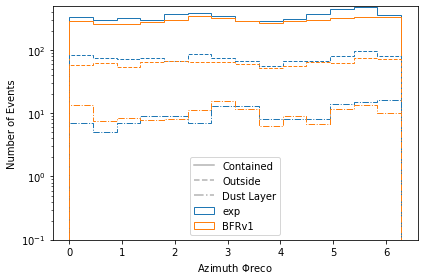

In [19]:
bins = np.linspace(0, 2*np.pi, 15)
dfs_to_plot = ['exp', 'BFRv1']
density = False

fig, ax = plt.subplots(figsize=(6, 4))

plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_azimuth', 
    bins=bins, fig=fig, ax=ax, ls='-', add_labels=True, density=density,
    mask_func=get_contained_mask,
    dfs_to_plot=dfs_to_plot,
)
plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_azimuth', 
    bins=bins, fig=fig, ax=ax, ls='--', add_labels=False, density=density,
    mask_func=get_non_contained_mask,
    dfs_to_plot=dfs_to_plot,
)
plot_hist(
    'EventGeneratorSelectedRecoNN_I3Particle_azimuth', 
    bins=bins, fig=fig, ax=ax, ls='-.', add_labels=False, density=density,
    mask_func=get_dust_layer_mask,
    dfs_to_plot=dfs_to_plot,
)
ax.set_xlabel(r'Azimuth $\Phi\mathrm{reco}$')

ax.plot(np.inf, np.inf, color='0.7', ls='-', label='Contained')
ax.plot(np.inf, np.inf, color='0.7', ls='--', label='Outside')
ax.plot(np.inf, np.inf, color='0.7', ls='-.', label='Dust Layer')

ax.legend(loc='lower center')
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'containment_hist_azimuth.png'))


## Event Number Plots

x_width: 23.333333333333343
y_width: 0.17670099985546606


  0%|          | 0/15 [00:00<?, ?it/s]

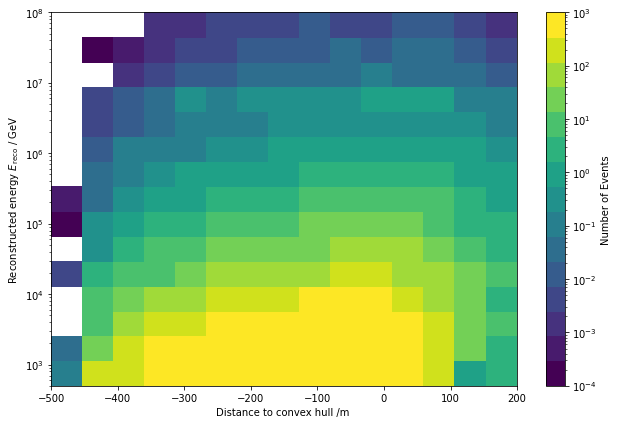

In [20]:
def quantity_func(df, mask):
    return np.sum(df['weights'][mask])

x_key = 'distance_hull'
y_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'
x_edges = np.linspace(-500, 200, 16)
y_edges_exp = np.linspace(np.log10(500), 8, 16)
y_edges = 10**y_edges_exp
x_width = 0.5*np.diff(x_edges)[0]
y_width = 0.5*np.diff(y_edges_exp)[0]
print('x_width:', x_width)
print('y_width:', y_width)

fig, ax = plot_2d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    y_key=y_key, 
    quantity_func=quantity_func, 
    x_edges=x_edges, 
    y_edges=y_edges, 
    x_width=x_width, 
    y_width=y_width,
    y_width_in_log=True,
    vmin=1e-4, vmax=1e3,
    #norm='linear',
    label_quantity='Number of Events',
)
ax.set_yscale('log')
fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'num_events2d_{}_{}.png'.format(x_key, y_key)))


x_width: 11.666666666666657
y_width: 16.666666666666657


  0%|          | 0/30 [00:00<?, ?it/s]

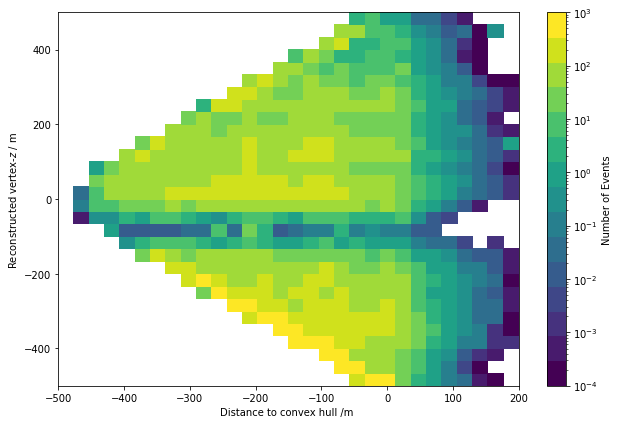

In [21]:
def quantity_func(df, mask):
    return np.sum(df['weights'][mask])

x_key = 'distance_hull'
y_key = 'EventGeneratorSelectedRecoNN_I3Particle_z'

x_edges = np.linspace(-500, 200, 31)
y_edges = np.linspace(-500, 500, 31)
x_width = 0.5*np.diff(x_edges)[0]
y_width = 0.5*np.diff(y_edges)[0]
print('x_width:', x_width)
print('y_width:', y_width)

fig, ax = plot_2d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    y_key=y_key, 
    quantity_func=quantity_func, 
    x_edges=x_edges, 
    y_edges=y_edges, 
    x_width=x_width, 
    y_width=y_width,
    y_width_in_log=False,
    vmin=1e-4, vmax=1e3,
    #norm='linear',
    label_quantity='Number of Events',
)

fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'num_events2d_{}_{}.png'.format(x_key, y_key)))


x_width: 16.666666666666657
y_width: 0.08835049992773292


  0%|          | 0/30 [00:00<?, ?it/s]

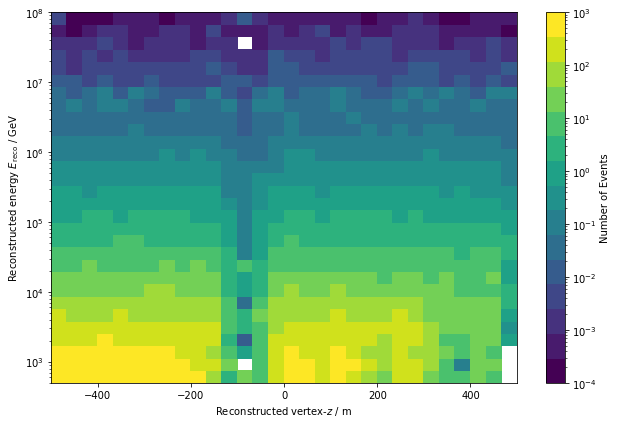

In [22]:
def quantity_func(df, mask):
    return np.sum(df['weights'][mask])

y_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'
x_key = 'EventGeneratorSelectedRecoNN_I3Particle_z'


x_edges = np.linspace(-500, 500, 31)
y_edges_exp = np.linspace(np.log10(500), 8, 31)
y_edges = 10**y_edges_exp
x_width = 0.5*np.diff(x_edges)[0]
y_width = 0.5*np.diff(y_edges_exp)[0]
print('x_width:', x_width)
print('y_width:', y_width)

fig, ax = plot_2d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    y_key=y_key, 
    quantity_func=quantity_func, 
    x_edges=x_edges, 
    y_edges=y_edges, 
    x_width=x_width, 
    y_width=y_width,
    y_width_in_log=True,
    vmin=1e-4, vmax=1e3,
    #norm='linear',
    label_quantity='Number of Events',
)
ax.set_yscale('log')
fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'num_events2d_{}_{}.png'.format(x_key, y_key)))


## Median Opening Angle Plots

  0%|          | 0/15 [00:00<?, ?it/s]

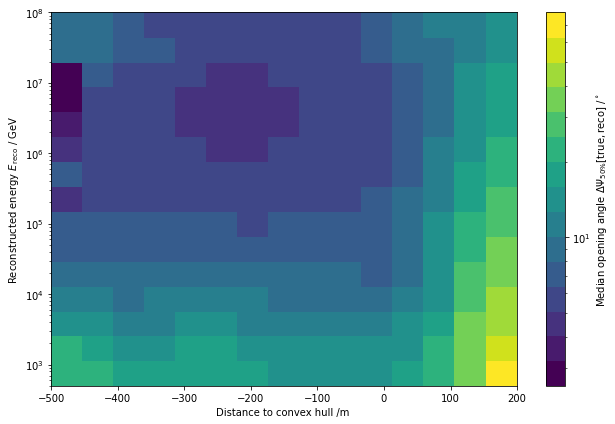

In [23]:
def quantity_func(df, mask):
    return np.median(df['dpsi_deg'][mask])

x_key = 'distance_hull'
y_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'

fig, ax = plot_2d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    y_key=y_key, 
    quantity_func=quantity_func, 
    x_edges=np.linspace(-500, 200, 16), 
    y_edges=np.logspace(np.log10(500), 8, 16), 
    x_width=50, 
    y_width=0.5,
    y_width_in_log=True,
    #vmin=1, vmax=1e2,
    #norm='linear',
    label_quantity='Median opening angle $\Delta\Psi_{50\%}[\mathrm{true,reco}]~/^\circ$'
)
ax.set_yscale('log')
fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'opening_angle2d_{}_{}.png'.format(x_key, y_key)))


  0%|          | 0/50 [00:00<?, ?it/s]

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


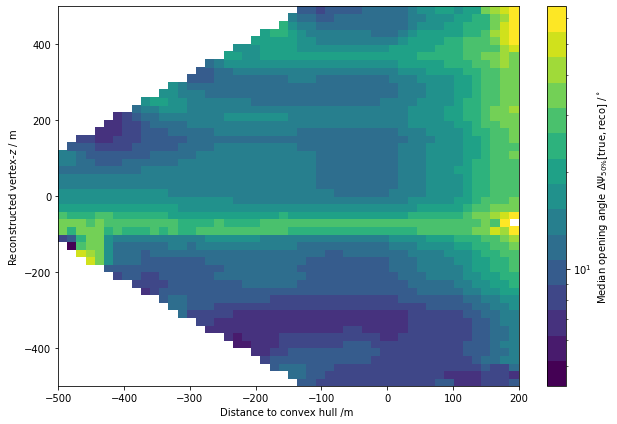

In [24]:
def quantity_func(df, mask):
    if np.sum(mask) == 0: return np.nan
    return np.median(df['dpsi_deg'][mask])

x_key = 'distance_hull'
y_key = 'EventGeneratorSelectedRecoNN_I3Particle_z'

fig, ax = plot_2d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    y_key=y_key, 
    quantity_func=quantity_func, 
    x_edges=np.linspace(-500, 200, 51), 
    y_edges=np.linspace(-500, 500, 51), 
    x_width=70, 
    y_width=50,
    y_width_in_log=False,
    vmin=None, vmax=None,
    #norm='linear',
    label_quantity='Median opening angle $\Delta\Psi_{50\%}[\mathrm{true,reco}]~/^\circ$'
)

fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'opening_angle2d_{}_{}.png'.format(x_key, y_key)))


  0%|          | 0/50 [00:00<?, ?it/s]

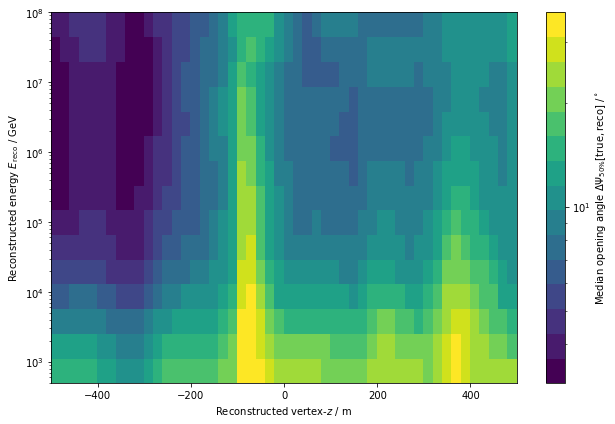

In [25]:
def quantity_func(df, mask):
    if np.sum(mask) == 0: return np.nan
    return np.median(df['dpsi_deg'][mask])

y_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'

x_key = 'EventGeneratorSelectedRecoNN_I3Particle_z'

fig, ax = plot_2d_quantity(
    df=dfs['BFRv1'], 
    x_key=x_key, 
    y_key=y_key, 
    quantity_func=quantity_func, 
    x_edges=np.linspace(-500, 500, 51), 
    y_edges=np.logspace(np.log10(500), 8, 16), 
    x_width=50, 
    y_width=0.5,
    y_width_in_log=True,
    vmin=None, vmax=None,
    #norm='linear',
    label_quantity='Median opening angle $\Delta\Psi_{50\%}[\mathrm{true,reco}]~/^\circ$'
)
ax.set_yscale('log')
fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'opening_angle2d_{}_{}.png'.format(x_key, y_key)))


## Sigma vs Energy

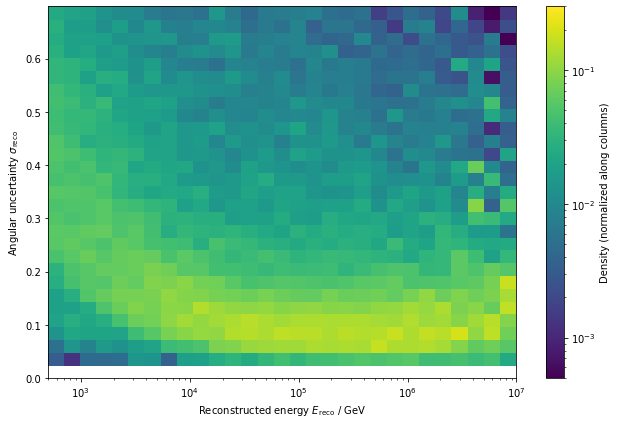

In [26]:
x_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'
y_key = 'angErr'
bins = (np.logspace(np.log10(500), 7, 30), np.linspace(0, np.deg2rad(40), 30))

fig, ax = plot_resolution(
    dfs['BFRv1'], 
    x_key=x_key,
    y_key=y_key,
    vmin=5e-4, vmax=3e-1,
    bins=bins,
)
ax.set_yscale('linear')
fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'correlation_{}_{}.png'.format(x_key, y_key)))

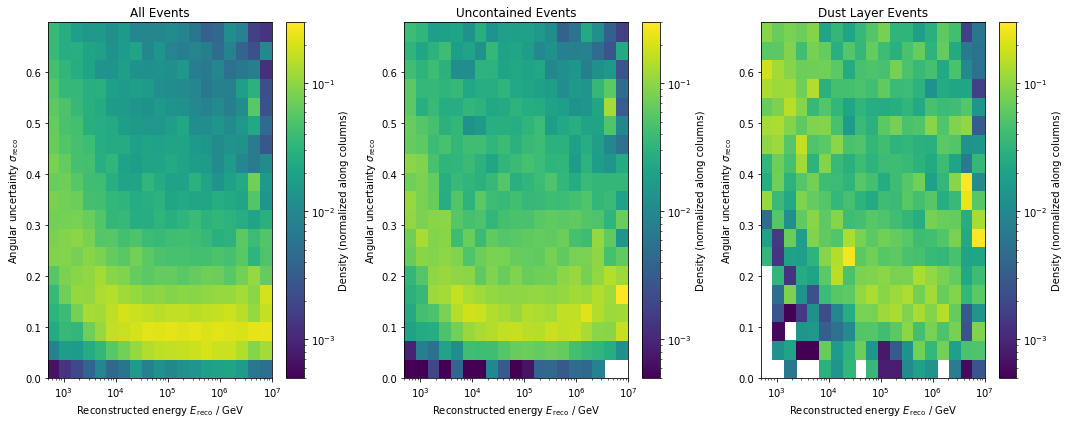

In [27]:
vmin = 5e-4
vmax = 3e-1

x_key = 'EventGeneratorSelectedRecoNN_I3Particle_energy'
y_key = 'angErr'
bins = (np.logspace(np.log10(500), 7, 20), np.linspace(0, np.deg2rad(40), 20))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].set_title('All Events')
plot_resolution(
    dfs['BFRv1'], 
    x_key=x_key,
    y_key=y_key,
    fig=fig, ax=axes[0],
    vmin=vmin, vmax=vmax,
    bins=bins,
)

axes[1].set_title('Uncontained Events')
plot_resolution(
    dfs['BFRv1'], 
    x_key=x_key,
    y_key=y_key,
    fig=fig, ax=axes[1],
    mask_func=get_non_contained_mask,
    vmin=vmin, vmax=vmax,
    bins=bins,
)

axes[2].set_title('Dust Layer Events')
plot_resolution(
    dfs['BFRv1'], 
    x_key=x_key,
    y_key=y_key,
    fig=fig, ax=axes[2],
    mask_func=get_dust_layer_mask,
    vmin=vmin, vmax=vmax,
    bins=bins,
)

for ax in axes:
    ax.set_yscale('linear')

fig.tight_layout()
fig.savefig(os.path.join(
    plot_dir, 'correlation_masked_{}_{}.png'.format(x_key, y_key)))

## Angular Coverage

In [28]:
from itertools import cycle
from dnn_cascade_selection.utils.notebook import coordinates
from dnn_cascade_selection.utils.notebook import ps_pdf


def get_ls_cycler():
    return cycle(['-', '--', ':', '-.'])

def get_color_cycler():
    return cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

def reweight(ow, energy, gamma, norm=1.0e-18, 
             e_pivot=1e5, energy_cutoff=None):
    """Reweight events according to power_law
    """
    n_types = 2.  # Dividing by n_types gives flux per flavor and per type
    weight = ow * norm * np.power(energy/e_pivot, -gamma) / n_types
    
    if energy_cutoff is not None:
        weight *= np.exp(-energy / energy_cutoff)
    return weight



Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.


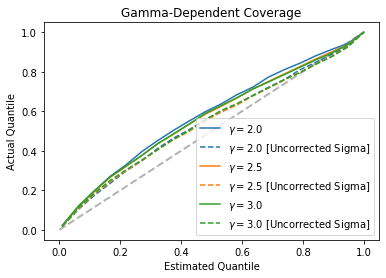

In [357]:
from tqdm.notebook import tqdm

every_nth = 110
gamma = 2.5
quantiles = np.linspace(0.01, 1, 20)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')
color_cycler = get_color_cycler()

# -------
# Current
# -------
for gamma in [2., 2.5, 3.]:
    color = next(color_cycler)
    weights = reweight(
        ow=dfs['BFRv1']['I3MCWeightDict_OneWeight'][::every_nth],
        energy=dfs['BFRv1']['I3MCWeightDict_PrimaryNeutrinoEnergy'][::every_nth],
        gamma=gamma,
    )
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=dfs['BFRv1']['dpsi'].values[::every_nth],
        sigma=dfs['BFRv1']['angErr'].values[::every_nth],
        weights=weights.values,
        quantiles=quantiles,
    )
    ax.plot(
        quantiles, cov_values, 
        ls='-', color=color,
        label='$\gamma={:.1f}$'.format(gamma)
    )
    
    # uncorrected
    if True:
        _, cov_values = ps_pdf.compute_von_mises_coverage(
            dPsi=dfs['BFRv1']['dpsi'].values[::every_nth],
            sigma=dfs['BFRv1']['EventGeneratorSelectedRecoNNCircularUncertainty'].values[::every_nth],
            weights=weights.values,
            quantiles=quantiles,
        )
        ax.plot(
            quantiles, cov_values, 
            ls='--', color=color,
            label='$\gamma={:.1f}$ [Uncorrected Sigma]'.format(gamma)
        )
    

ax.set_title('Gamma-Dependent Coverage')
ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.legend()
fig.savefig('{}/coverage_gamma.png'.format(plot_dir))


Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.
Clipping 1 events to max.


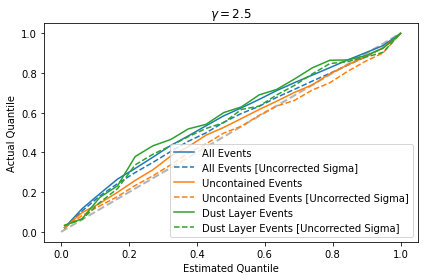

In [358]:
every_nth = 110
gamma = 2.5
quantiles = np.linspace(0.01, 1, 20)


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot((0., 1.), (0., 1.), ls='--', lw=2., color='0.7')

names = ['All Events', 'Uncontained Events', 'Dust Layer Events']
mask_funcs = [None, get_non_contained_mask, get_dust_layer_mask]

color_cycler = get_color_cycler()

for name, mask_func in zip(names, mask_funcs):
    
    color = next(color_cycler)
    
    if mask_func is None:
        mask = np.ones_like(dfs['BFRv1']['dpsi'].values, dtype=bool)
    else:
        mask = mask_func(dfs['BFRv1'])
    
    weights = reweight(
        ow=dfs['BFRv1']['I3MCWeightDict_OneWeight'][mask][::every_nth],
        energy=dfs['BFRv1']['I3MCWeightDict_PrimaryNeutrinoEnergy'][mask][::every_nth],
        gamma=gamma,
    )
        
    _, cov_values = ps_pdf.compute_von_mises_coverage(
        dPsi=dfs['BFRv1']['dpsi'].values[mask][::every_nth],
        sigma=dfs['BFRv1']['angErr'].values[mask][::every_nth],
        weights=weights.values,
        quantiles=quantiles,
    )
    ax.plot(
        quantiles, cov_values, 
        ls='-', color=color,
        label=name,
    )
    
    # uncorrected
    if True:
        _, cov_values = ps_pdf.compute_von_mises_coverage(
            dPsi=dfs['BFRv1']['dpsi'].values[mask][::every_nth],
            sigma=dfs['BFRv1']['EventGeneratorSelectedRecoNNCircularUncertainty'].values[mask][::every_nth],
            weights=weights.values,
            quantiles=quantiles,
        )
        ax.plot(
            quantiles, cov_values, 
            ls='--', color=color,
            label='{} [Uncorrected Sigma]'.format(name),
        )

ax.set_title('$\gamma={:.1f}$'.format(gamma))
ax.set_xlabel('Estimated Quantile')
ax.set_ylabel('Actual Quantile')
ax.legend()
fig.tight_layout()
fig.savefig('{}/coverage_masked.png'.format(plot_dir))


## Angular Resolution

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


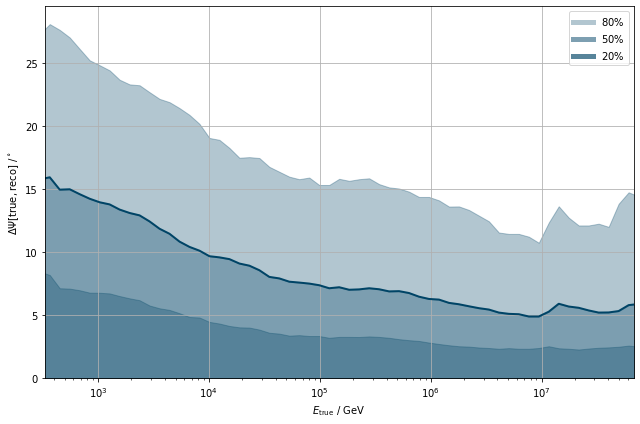

In [52]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_angular_resolution(
    dfs['BFRv1'],
    color=soft_colors[0],
    fig=fig, ax=ax,
)
ax.grid()

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


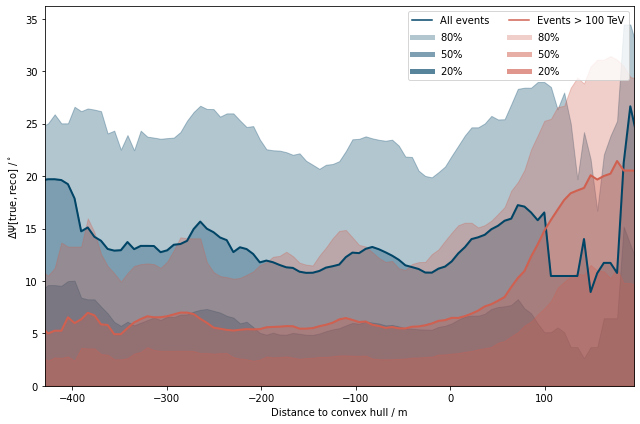

In [49]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(np.inf, np.inf, color=soft_colors[0], ls='-', label='All events')
plot_angular_resolution(
    dfs['BFRv1'],
    key_x='distance_hull',
    bins=(np.r_[-450:241:35.], np.r_[0:40.01:.01]),
    color=soft_colors[0],
    fig=fig, ax=ax,
    xscale='linear',
)

ax.plot(np.inf, np.inf, color=soft_colors[1], ls='-', label='Events > 100 TeV')
def get_above_100TeV_mask(df):
    return df['LabelsDeepLearning_PrimaryEnergy'] > 1e5

plot_angular_resolution(
    dfs['BFRv1'],
    key_x='distance_hull',
    bins=(np.r_[-450:241:35.], np.r_[0:40.01:.01]),
    color=soft_colors[1],
    fig=fig, ax=ax,
    xscale='linear',
    mask_func=get_above_100TeV_mask,
)
ax.set_xlabel('Distance to convex hull / m')

ax.legend(ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'angular_res_distance_hull.png'))

##### Contained/Outside

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


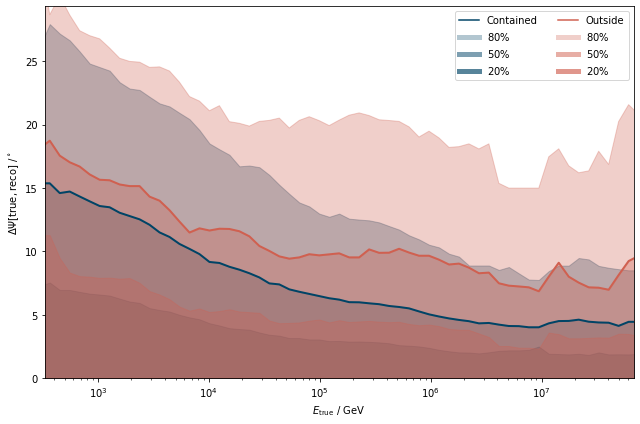

In [318]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(np.inf, np.inf, color=soft_colors[0], ls='-', label='Contained')
plot_angular_resolution(
    dfs['BFRv1'],
    mask_func=get_contained_mask,
    color=soft_colors[0],
    fig=fig, ax=ax,
)

ax.plot(np.inf, np.inf, color=soft_colors[1], ls='-', label='Outside')
plot_angular_resolution(
    dfs['BFRv1'],
    mask_func=get_non_contained_mask,
    color=soft_colors[1],
    fig=fig, ax=ax,
)

if False:
    ax.plot(np.inf, np.inf, color=soft_colors[2], ls='-', label='Dust Layer')
    plot_angular_resolution(
        dfs['BFRv1'],
        mask_func=get_dust_layer_mask,
        color=soft_colors[2],
        fig=fig, ax=ax,
    )


ax.legend(ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'angular_res_containment.png'))

##### Dust Layer

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


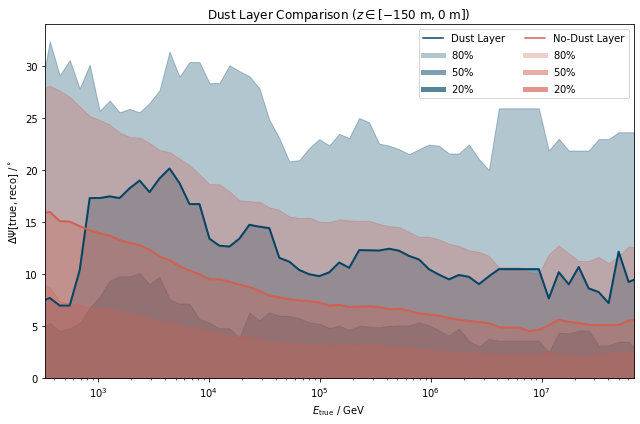

In [319]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(np.inf, np.inf, color=soft_colors[0], ls='-', label='Dust Layer')
plot_angular_resolution(
    dfs['BFRv1'],
    mask_func=get_dust_layer_mask,
    color=soft_colors[0],
    fig=fig, ax=ax,
)

ax.plot(np.inf, np.inf, color=soft_colors[1], ls='-', label='No-Dust Layer')
plot_angular_resolution(
    dfs['BFRv1'],
    mask_func=get_non_dust_layer_mask,
    color=soft_colors[1],
    fig=fig, ax=ax,
)

ax.set_title('Dust Layer Comparison ($z \in [-150~\mathrm{m}, 0~\mathrm{m}]$)')
ax.legend(ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'angular_res_dust_layer.png'))

## Energy Resolution

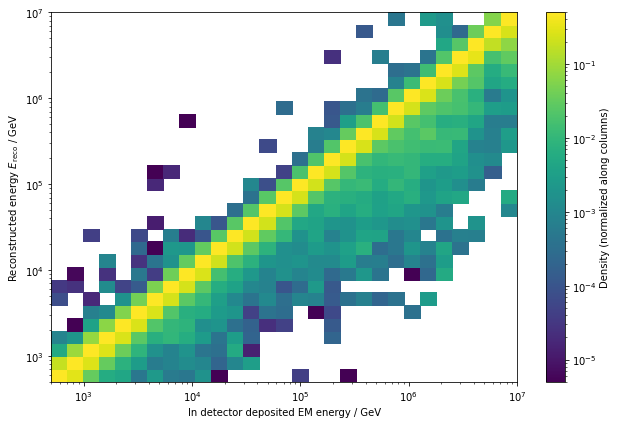

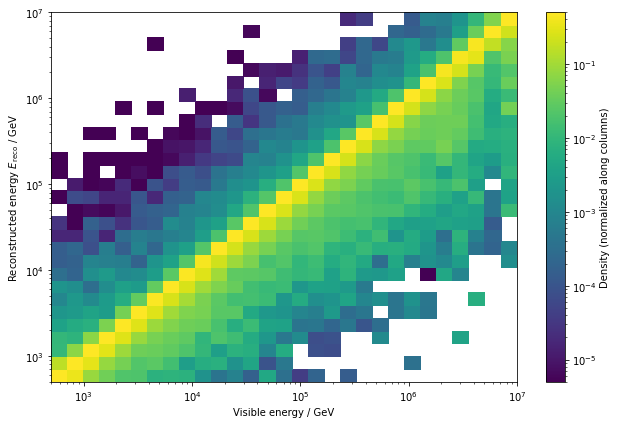

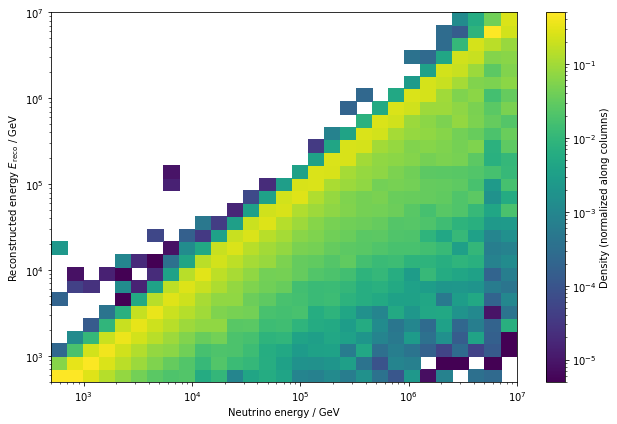

In [320]:
reco_keys = [
    'EventGeneratorSelectedRecoNN_I3Particle',
]
energy_keys = [
    'LabelsDeepLearning_TotalDepositedEnergy',
    'LabelsDeepLearning_EnergyVisible',
    'LabelsDeepLearning_PrimaryEnergy',
]

for reco_key in reco_keys:
    for energy_key in energy_keys:
        fig, ax = plot_resolution(
            dfs['BFRv1'], 
            x_key=energy_key,
            y_key=reco_key + '_energy',
            vmin=5e-6, vmax=5e-1,
        )
        fig.tight_layout()
        fig.savefig(os.path.join(
            plot_dir, 'correlation_{}_{}.png'.format(reco_key, energy_key)))

##### Masked energy resolutions

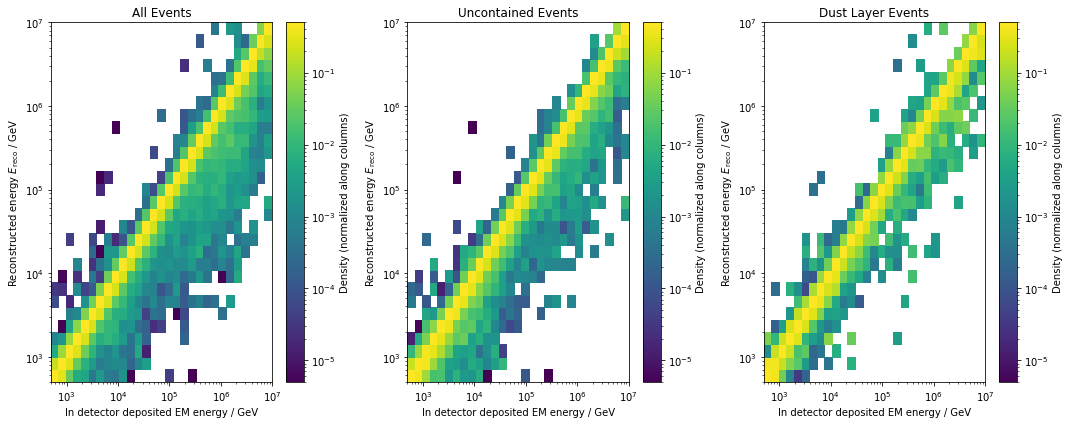

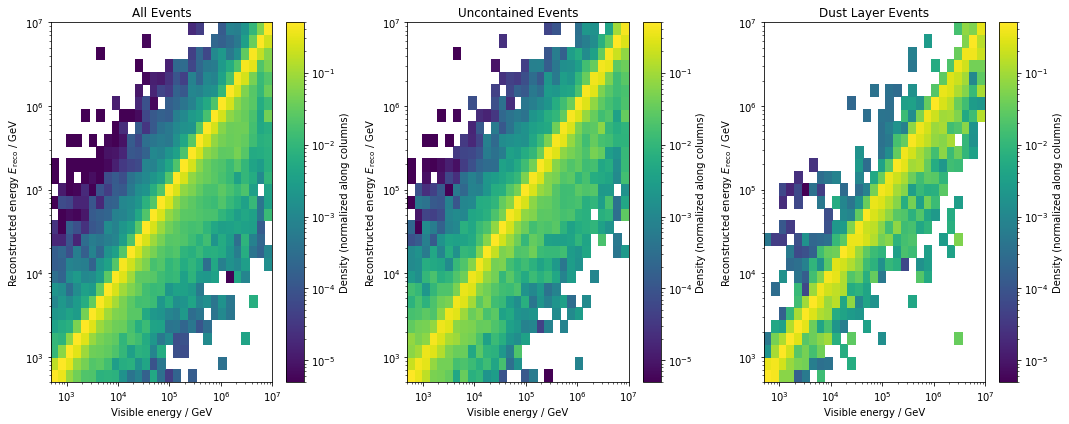

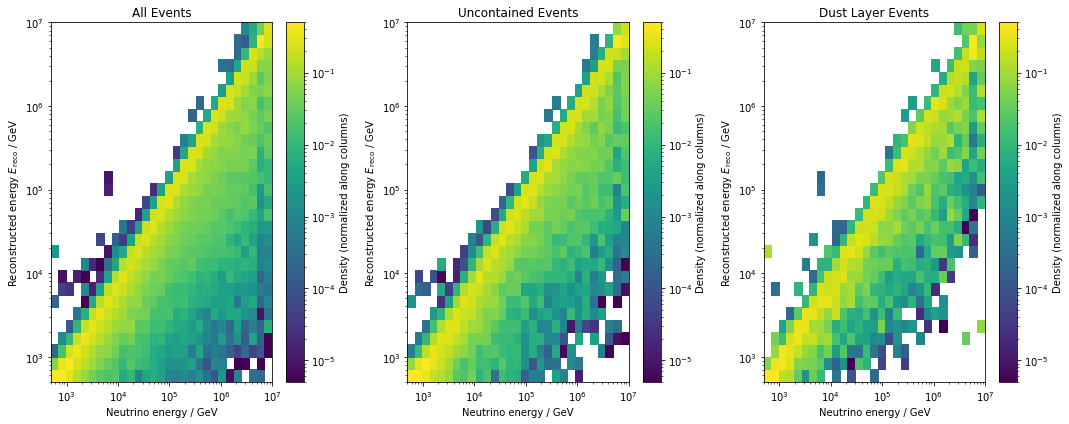

In [321]:
reco_keys = [
    'EventGeneratorSelectedRecoNN_I3Particle',
]
energy_keys = [
    'LabelsDeepLearning_TotalDepositedEnergy',
    'LabelsDeepLearning_EnergyVisible',
    'LabelsDeepLearning_PrimaryEnergy',
]
vmin = 5e-6
vmax = 5e-1

for reco_key in reco_keys:
    for energy_key in energy_keys:
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        
        axes[0].set_title('All Events')
        plot_resolution(
            dfs['BFRv1'], 
            x_key=energy_key,
            y_key=reco_key + '_energy',
            fig=fig, ax=axes[0],
            vmin=vmin, vmax=vmax,
        )
        
        axes[1].set_title('Uncontained Events')
        plot_resolution(
            dfs['BFRv1'], 
            x_key=energy_key,
            y_key=reco_key + '_energy',
            fig=fig, ax=axes[1],
            mask_func=get_non_contained_mask,
            vmin=vmin, vmax=vmax,
        )
        
        axes[2].set_title('Dust Layer Events')
        plot_resolution(
            dfs['BFRv1'], 
            x_key=energy_key,
            y_key=reco_key + '_energy',
            fig=fig, ax=axes[2],
            mask_func=get_dust_layer_mask,
            vmin=vmin, vmax=vmax,
        )
        
        fig.tight_layout()
        fig.savefig(os.path.join(
            plot_dir, 'correlation_masked_{}_{}.png'.format(reco_key, energy_key)))